# Quickstart
First let import the modules to work with.  Some functionalities of **MolDrug** may not be available on PyPi or Conda yet. This could be because the new version is not yet release, but in brief it is going to be. You could install directly from the repo if some problem pops up. Just paste the following in a code cell:
```bash
! pip install git+https://github.com/ale94mleon/MolDrug.git@main
```

In [4]:
from rdkit import Chem
from moldrug import utils, fitness
from moldrug.data import receptor_pdbqt, ligands, boxes
import tempfile, os, gzip, shutil, requests
from multiprocessing import cpu_count

In [5]:
# Remember to change to your vina executable
# If you define as a path, it must be absolute
vina_executable = '/Users/klimt/GIT/docking/bin/vina'

In [6]:
# Defining the wd and change directory
wd = 'wd'
os.mkdir(wd)
os.chdir(wd)

We will use some test examples from `moldrug.data` module.

In [7]:
# Creating receptors files
r_x0161_file = 'r_x0161.pdbqt'
with open(r_x0161_file, 'w') as r:
    r.write(receptor_pdbqt.r_x0161)

Now let's download the crem data base. Here we are downloading the smaller one. But consider to visit [CReM](https://github.com/DrrDom/crem) for more information about how to use and create the data base of fragments.

In [8]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = 'crem.db.gz'
crem_db_path = 'crem.db'
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Now let's initialize the `GA` class. 

In [9]:
maxiter = 3
popsize = 20
njobs = 2

out = utils.GA(
    seed_mol=Chem.MolFromSmiles(ligands.r_x0161),
    maxiter=maxiter,
    popsize=popsize,
    crem_db_path = crem_db_path,
    pc = 1,
    get_similar = False,
    mutate_crem_kwargs = {
        'radius':3,
        'min_size':1,
        'max_size':8,
        'min_inc':-5,
        'max_inc':3,
        'ncores':cpu_count(),
    },
    costfunc = fitness.Cost,
    costfunc_kwargs = {
        'vina_executable': vina_executable,
        'receptor_pdbqt_path': r_x0161_file,
        'boxcenter' : boxes.r_x0161["A"]['boxcenter'] ,
        'boxsize': boxes.r_x0161["A"]['boxsize'],
        'exhaustiveness': 4,
        'ncores': int(cpu_count() / njobs),
        'num_modes': 1,
        'vina_seed':1234,
    },
    save_pop_every_gen = 20,
    deffnm = 'pop_test_single_receptor',
    AddHs=True,
    randomseed = 1234,
)


Then let's call the class

In [10]:
out(njobs = njobs)



Creating the first population with 20 members:


100%|██████████| 20/20 [00:32<00:00,  1.60s/it]

Initial Population: Best Individual: Individual(idx = 12, smiles = COc1cc(-c2ccc(S(N)(=O)=O)cc2)no1, cost = 0.9175374802925078)
Accepted rate: 20 / 20

File pop_test_single_receptor_pop.sdf was createad!


Evaluating generation 1 / 3:


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]

Generation 1: Best Individual: Individual(idx = 29, smiles = NS(=O)(=O)c1ccc(-n2c(=O)[nH][nH]c2=O)cc1, cost = 0.7913552585960847).
Accepted rate: 4 / 20



Evaluating generation 2 / 3:


100%|██████████| 20/20 [00:39<00:00,  1.98s/it]

Generation 2: Best Individual: Individual(idx = 48, smiles = COC(=O)c1ccc(S(=O)(=O)c2nonc2C)cc1, cost = 0.7713945451967487).
Accepted rate: 3 / 20



Evaluating generation 3 / 3:


100%|██████████| 19/19 [00:38<00:00,  2.02s/it]

File pop_test_single_receptor_pop.sdf was createad!
Generation 3: Best Individual: Individual(idx = 62, smiles = NS(=O)(=O)c1ccc(C(=O)n2cc([N+](=O)[O-])cn2)cc1, cost = 0.7508731969406554).
Accepted rate: 3 / 19


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 3 generations witha population of 20 individuals. A total number of 79 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Final Individual: Individual(idx = 62, smiles = NS(=O)(=O)c1ccc(C(=O)n2cc([N+](=O)[O-])cn2)cc1, cost = 0.7508731969406554)
The cost function dropped in 0.24912680305934465 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Total time (3 generations): 227.08 (s).
Finished at Wed Dec  6 19:34:16 2023.



This is a very silly example. In real life, you should increase the population size and the number of generation. In this way we explore in a better way the chemical space. The `GA` class has some nice methods that give you an idea of the obtained results.

In [11]:
out.to_dataframe().tail()

,pdbqt,cost,idx,genID,kept_gens,qed,sa_score,vina_score
74,MODEL 1\nREMARK VINA RESULT: -6.432 0....,1.000000,76,3,{},0.853010,7.198377,-6.432
75,MODEL 1\nREMARK VINA RESULT: -4.912 0....,1.000000,55,2,{},0.526817,7.840106,-4.912
76,MODEL 1\nREMARK VINA RESULT: -6.202 0....,0.874761,60,3,{3},0.622313,6.709553,-6.202
77,MODEL 1\nREMARK VINA RESULT: -6.351 0....,0.771395,48,2,"{2, 3}",0.773923,6.183109,-6.351
78,MODEL 1\nREMARK VINA RESULT: -5.730 0....,1.000000,64,3,{},0.391173,7.907590,-5.730


You could save the entire class for future in a compressed or uncompressed pickle file. Here I just saved the file in the temporal directory, you could change the path to your current working directory.

In [12]:
out.pickle(f"NumGens_{out.NumGens}_PopSize_{popsize}", compress=True)

Could be that after a long simulation we would like to perform a different searching strategy over the last population. This is really simple, we could "initialize" again the `out` instance with a different set of parameters. Let say that we would like to be close to the last solutions. Then we could use the parameters: `min_size=0, max_size=1, min_inc=-1, max_inc=1`.This flavor will add, delate mutate heavy atoms or change hydrogens to heavy atoms.

In [13]:
out.maxiter = 5
out.mutate_crem_kwargs = {
        'radius':3,
        'min_size':0,
        'max_size':1,
        'min_inc':-1,
        'max_inc':1,
        'ncores':cpu_count(),
    }

And run again the class

In [14]:
out(njobs = njobs)

File pop_test_single_receptor_pop.sdf was createad!
Evaluating generation 4 / 8:


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]

Generation 4: Best Individual: Individual(idx = 87, smiles = O=C(c1ccc(S(=O)(=O)NCl)cc1)n1cc([N+](=O)[O-])cn1, cost = 0.6956485232070193).
Accepted rate: 12 / 20



Evaluating generation 5 / 8:


100%|██████████| 20/20 [00:39<00:00,  1.96s/it]

Generation 5: Best Individual: Individual(idx = 87, smiles = O=C(c1ccc(S(=O)(=O)NCl)cc1)n1cc([N+](=O)[O-])cn1, cost = 0.6956485232070193).
Accepted rate: 9 / 20



Evaluating generation 6 / 8:


100%|██████████| 18/18 [00:35<00:00,  1.99s/it]

Generation 6: Best Individual: Individual(idx = 123, smiles = CC(C)C(=O)c1ccc(NC(=O)C(C)(C)CO)cc1, cost = 0.6449594565931867).
Accepted rate: 8 / 18



Evaluating generation 7 / 8:


100%|██████████| 16/16 [00:35<00:00,  2.23s/it]

Generation 7: Best Individual: Individual(idx = 141, smiles = COC(=O)c1ccc(S(=O)(=O)c2nonc2C)cc1C#N, cost = 0.635027075616337).
Accepted rate: 7 / 16



Evaluating generation 8 / 8:


100%|██████████| 18/18 [00:40<00:00,  2.27s/it]

File pop_test_single_receptor_pop.sdf was createad!
Generation 8: Best Individual: Individual(idx = 141, smiles = COC(=O)c1ccc(S(=O)(=O)c2nonc2C)cc1C#N, cost = 0.635027075616337).
Accepted rate: 11 / 18


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 8 generations witha population of 20 individuals. A total number of 167 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Final Individual: Individual(idx = 141, smiles = COC(=O)c1ccc(S(=O)(=O)c2nonc2C)cc1C#N, cost = 0.635027075616337)
The cost function dropped in 0.364972924383663 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Total time (5 generations): 246.32 (s).
Finished at Wed Dec  6 19:38:22 2023.



As you can see the `GA` class is updated rather that replaced. This is a perfect feature for rerun with different ideas. As you see the number of generations is also updated as well the number of calls.

In [15]:
print(out.NumGens, out.NumCalls)

8 2


The same idea is for the rest of the methods and atributtes

In [16]:
out.to_dataframe().tail()

,pdbqt,cost,idx,genID,kept_gens,qed,sa_score,vina_score
162,MODEL 1\nREMARK VINA RESULT: -6.351 0....,0.771395,48,2,"{2, 3, 4, 5, 6}",0.773923,6.183109,-6.351
163,MODEL 1\nREMARK VINA RESULT: -6.702 0....,0.735240,148,7,{7},0.468501,5.880810,-6.702
164,MODEL 1\nREMARK VINA RESULT: -6.791 0....,0.707722,167,8,{8},0.612676,6.039513,-6.791
165,MODEL 1\nREMARK VINA RESULT: -5.730 0....,1.000000,64,3,{},0.391173,7.907590,-5.730
166,MODEL 1\nREMARK VINA RESULT: -6.614 0....,0.727831,146,7,"{8, 7}",0.476884,5.640853,-6.614


This is the best solution of this simulation (in your case you could get a different one):

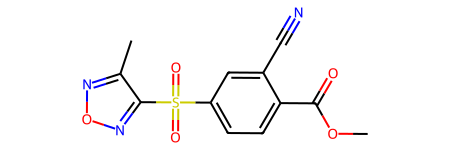

In [17]:
Chem.MolFromSmiles(out.pop[0].smiles)

And here is the input

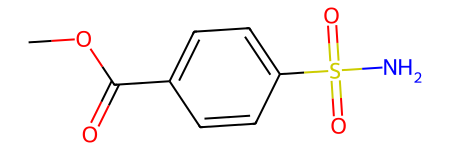

In [18]:
from rdkit import Chem
Chem.MolFromSmiles("COC(=O)C=1C=CC(=CC1)S(=O)(=O)N")

Printing some information

Initial vina score: -5.209. Final vina score: -6.998
sascorer of the best Individual: 5.830870436334594
QED of the best Individual: 0.7649966959899149


,value
NumHAcceptors,8.000000
NumHDonors,0.000000
wt,307.287000
MLogP,0.869100
NumRotatableBonds,5.000000
TPSA,123.150000
FractionCSP3,0.166667
HeavyAtomCount,21.000000
NHOHCount,0.000000
NOCount,8.000000


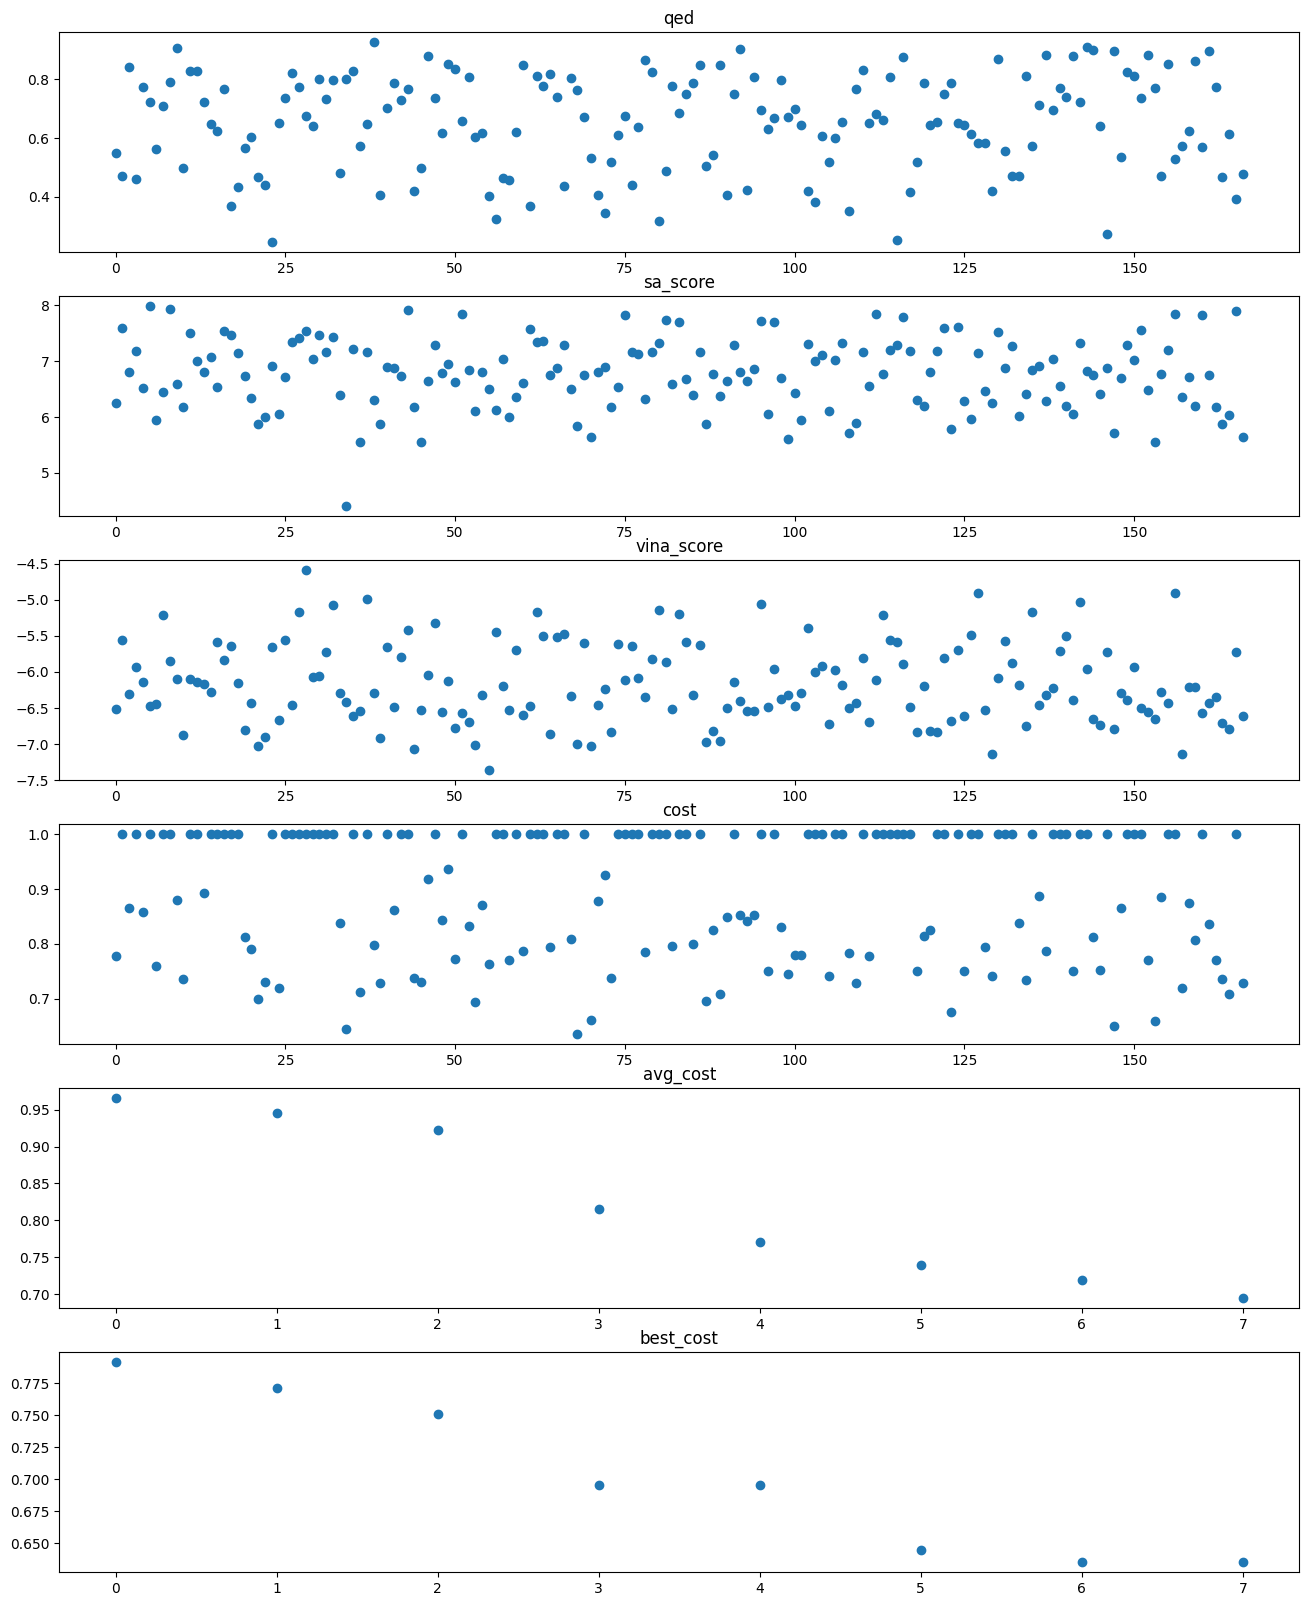

In [19]:
import matplotlib.pyplot as plt
from moldrug import utils
import pandas as pd
sascorer = utils.import_sascorer()


fig, ax = plt.subplots(nrows = 6, figsize = (16,20))

ax[0].plot(range(len(out.SawIndividuals)),[Individual.qed for Individual in out.SawIndividuals], 'o')
ax[0].set(title = 'qed')

ax[1].plot(range(len(out.SawIndividuals)),[Individual.sa_score for Individual in out.SawIndividuals], 'o')
ax[1].set(title = 'sa_score')

ax[2].plot(range(len(out.SawIndividuals)),[Individual.vina_score for Individual in out.SawIndividuals], 'o')
ax[2].set(title = 'vina_score')

ax[3].plot(range(len(out.SawIndividuals)),[Individual.cost for Individual in out.SawIndividuals], 'o')
ax[3].set(title = 'cost')

ax[4].plot(range(len(out.avg_cost)),out.avg_cost, 'o')
ax[4].set(title = 'avg_cost')

ax[5].plot(range(len(out.best_cost)),out.best_cost, 'o')
ax[5].set(title = 'best_cost')


print(f"Initial vina score: {out.InitIndividual.vina_score}. Final vina score: {out.pop[0].vina_score}")
print(f"sascorer of the best Individual: {sascorer.calculateScore(out.pop[0].mol)}")
print(f"QED of the best Individual: {fitness.QED.weights_mean(out.pop[0].mol)}")

pd.DataFrame(utils.lipinski_profile(out.pop[0].mol), index=['value']).T

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from moldrug.utils import Individual
import numpy as np

# This function is possible from version 2.2.0

def plot_dist(individuals:List[Individual], properties:List[str], every_gen:int = 1):


    # Set up the matplotlib figure
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(nrows = len(properties), figsize=(25, 25))

    SawIndividuals = utils.to_dataframe(individuals).drop(['pdbqt'], axis = 1).replace([np.inf, -np.inf], np.nan).dropna()
    SawIndividuals = SawIndividuals[SawIndividuals['kept_gens'].map(len) != 0].reset_index(drop=True)
    gen_idxs = sorted(set(item for sublist in SawIndividuals['kept_gens'] for item in sublist))
    NumGens = max(gen_idxs)

    # Set pop to the initial population and pops out the first gen
    pop = SawIndividuals[SawIndividuals.genID == gen_idxs.pop(0)].sort_values(by=["cost"])
    pops = pop.copy()
    for gen_idx in gen_idxs:
        idx = [i for i in range(SawIndividuals.shape[0]) if gen_idx in SawIndividuals.loc[i,'kept_gens']]
        pop = SawIndividuals.copy().iloc[idx,:].assign(genID=gen_idx)
        pops = pd.concat([pops, pop.copy()])
    # Draw a violinplot with a narrow bandwidth than the default
    pops = pops.loc[pops['genID'].isin([gen for gen in range(0, NumGens+every_gen, every_gen)])]
    for i, prop in enumerate(properties):
        sns.violinplot(x = 'genID', hue='genID', y = prop, data=pops, palette="Set3", bw_adjust=.2, cut=0, linewidth=1, ax=axes[i], legend = False)

    return fig, axes


(<Figure size 2500x2500 with 4 Axes>,
 array([<Axes: xlabel='genID', ylabel='qed'>,
        <Axes: xlabel='genID', ylabel='sa_score'>,
        <Axes: xlabel='genID', ylabel='vina_score'>,
        <Axes: xlabel='genID', ylabel='cost'>], dtype=object))

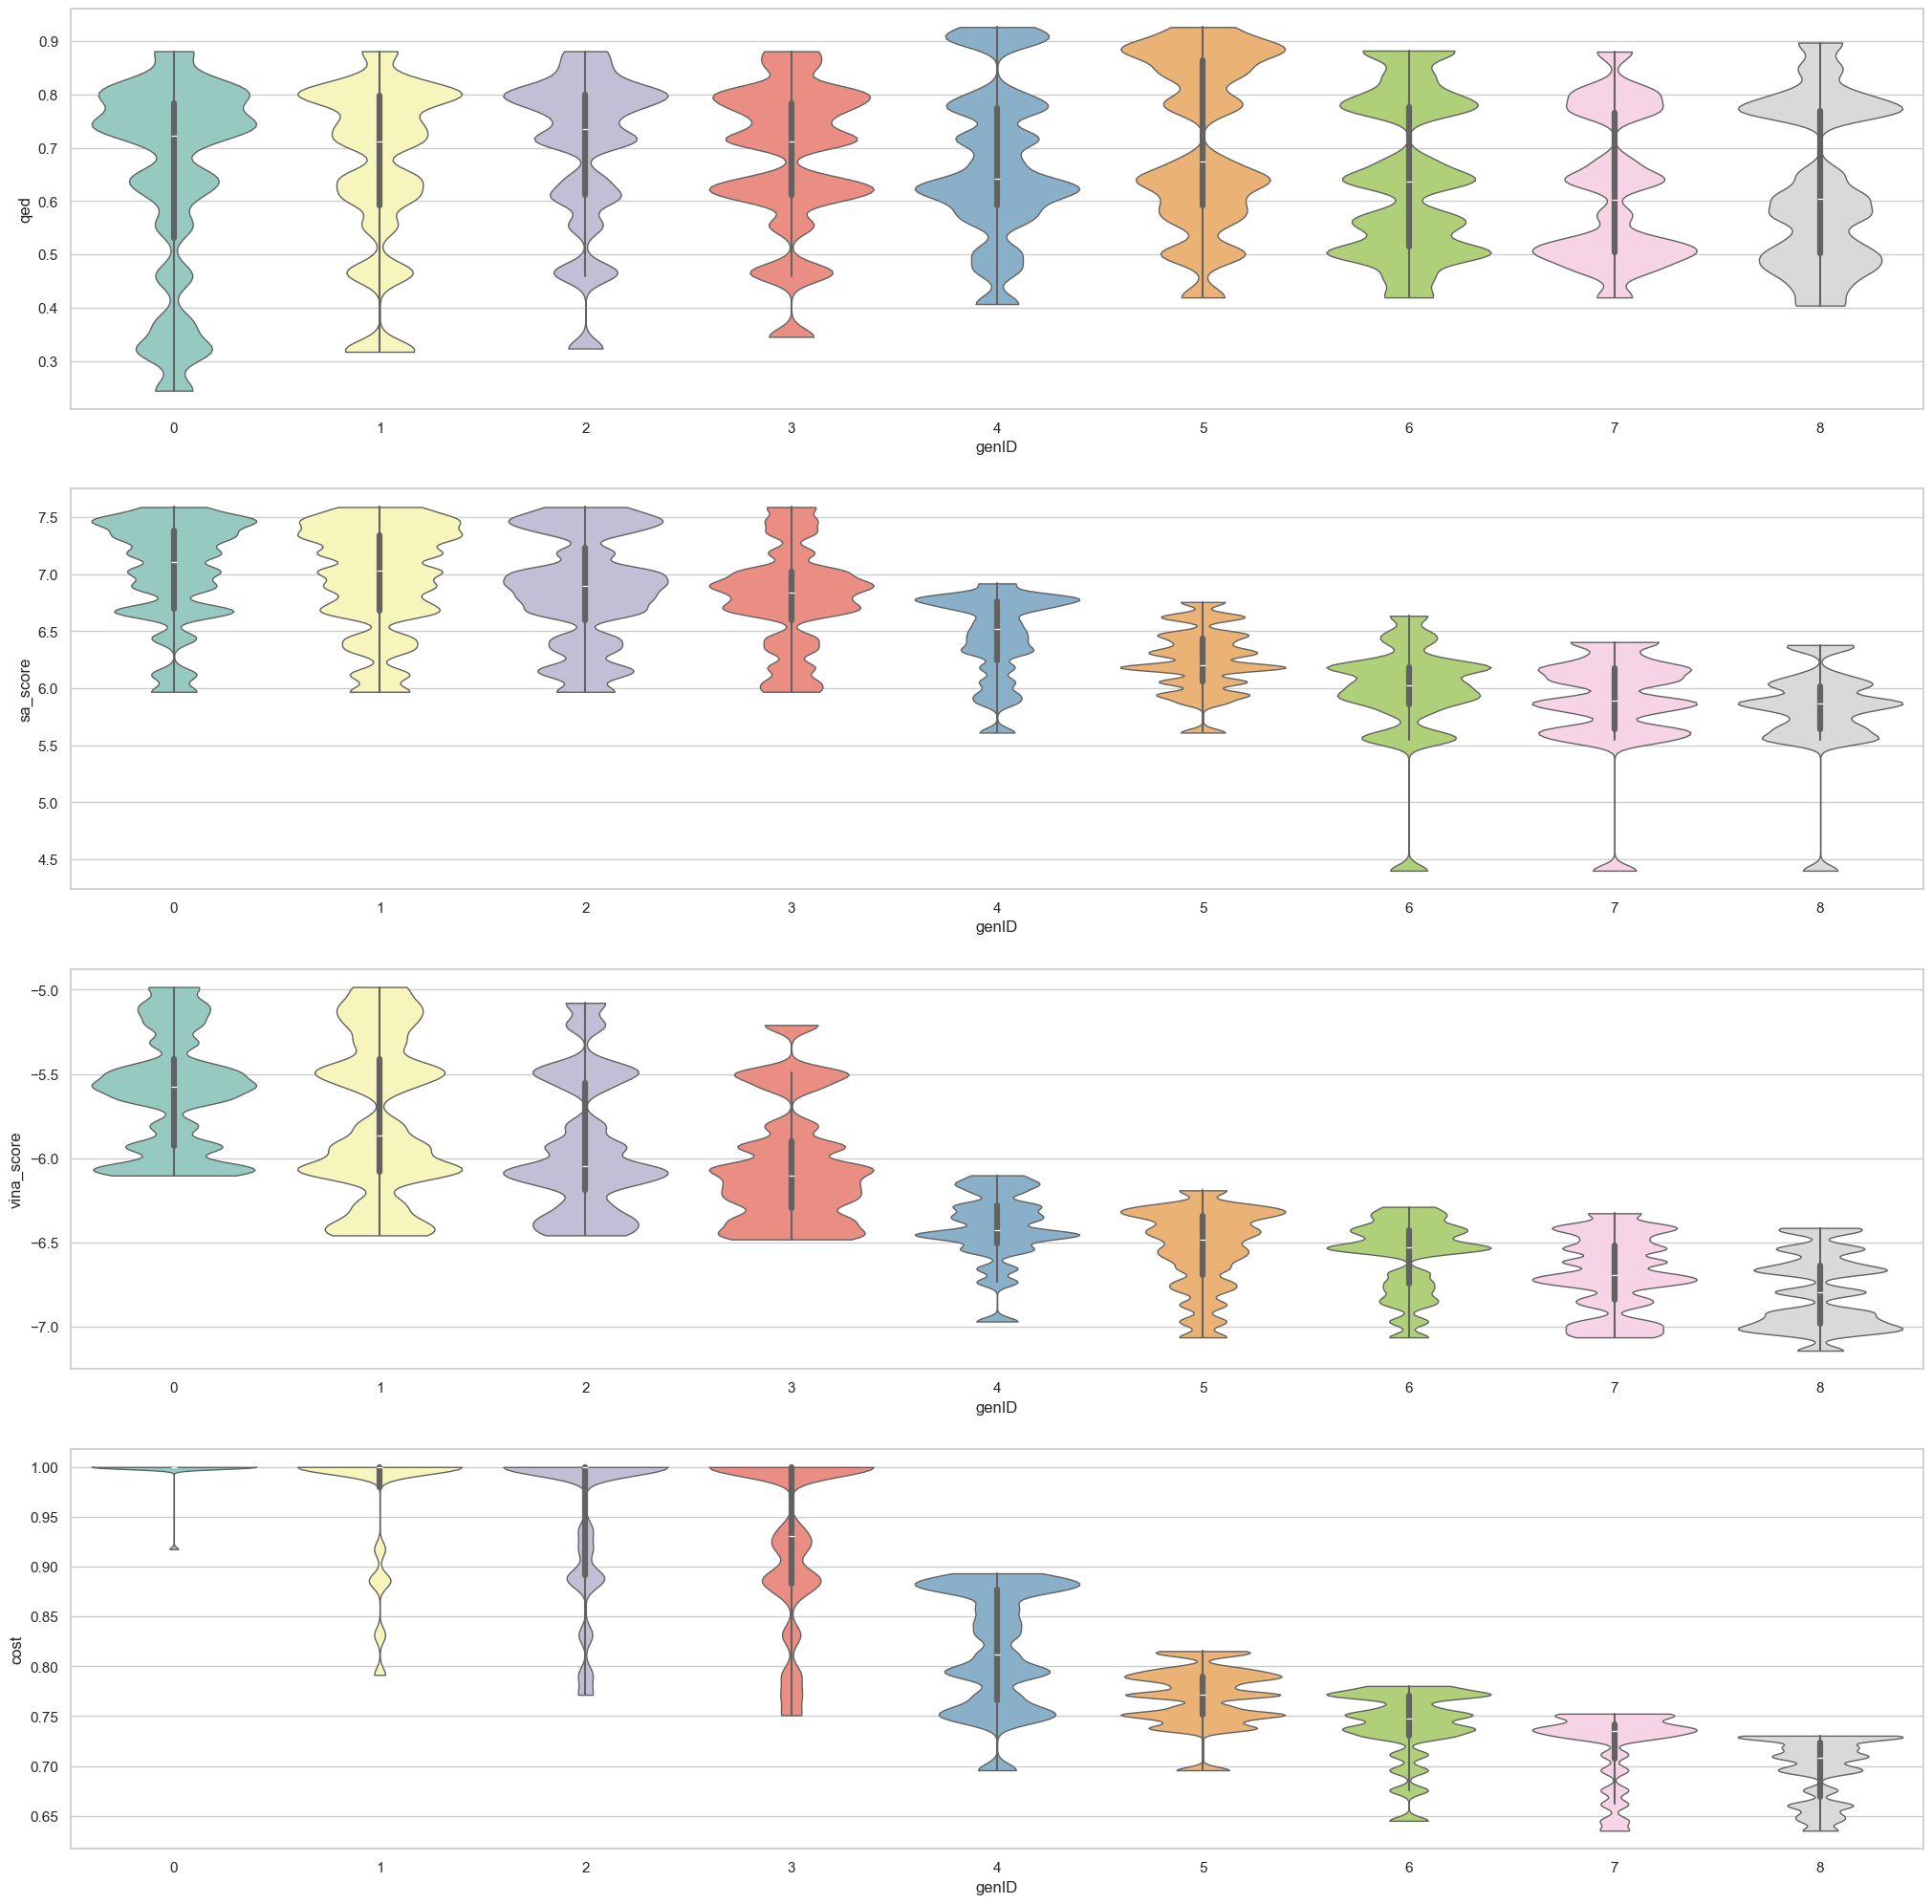

In [21]:
plot_dist(out.SawIndividuals, properties=['qed', 'sa_score', 'vina_score', 'cost'])